# Credit Risk Assessment - Logistic Regression Model (SMOTE-Balanced)

This notebook trains a Logistic Regression model using **preprocessed data with SMOTE** from the data pipeline.

**What this notebook does:**
1. Load preprocessed data (with SMOTE already applied)
2. Train Logistic Regression model
3. Optimize classification threshold
4. Calibrate probabilities
5. Evaluate performance
6. Compare with baseline and XGBoost

**Data Pipeline Handles:**
- ✅ Data loading
- ✅ Train/val/test splits
- ✅ Preprocessing
- ✅ Feature engineering (12 risk indicators)
- ✅ SMOTE resampling (verified)
- ✅ Saved to `data/processed/`

## 1. Setup and Load Data

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from src.data_pipeline import load_processed_data
from src.config import MODELS_DIR, RESULTS_DIR, FIGURES_DIR
from src.evaluation import ModelEvaluator
from src.utils import setup_logging, set_seed
import pickle

# Setup
setup_logging()
set_seed(42)

print("✓ Imports successful!")

✓ Imports successful!


In [2]:
print("="*80)
print("LOADING PREPROCESSED DATA (WITH SMOTE)")
print("="*80)

# Load preprocessed data from data pipeline
X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data()

print(f"\n✓ Data loaded successfully!")
print(f"\nDataset sizes:")
print(f"  Training: {len(X_train):,} samples, {X_train.shape[1]} features")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test: {len(X_test):,} samples")

print(f"\nTraining set class distribution (SMOTE-balanced):")
train_dist = y_train.value_counts().sort_index()
print(f"  Class 0 (good): {train_dist[0]:,} ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"  Class 1 (bad): {train_dist[1]:,} ({train_dist[1]/len(y_train)*100:.1f}%)")
print(f"  Imbalance ratio: {train_dist[0]/train_dist[1]:.2f}:1")

INFO:src.data_pipeline:Loading processed data...


LOADING PREPROCESSED DATA (WITH SMOTE)


INFO:src.data_pipeline:✓ Training data (SMOTE-balanced): (364313, 103)
INFO:src.data_pipeline:✓ Validation data: (75000, 103)
INFO:src.data_pipeline:✓ Test data: (100000, 103)



✓ Data loaded successfully!

Dataset sizes:
  Training: 364,313 samples, 103 features
  Validation: 75,000 samples
  Test: 100,000 samples

Training set class distribution (SMOTE-balanced):
  Class 0 (good): 260,224 (71.4%)
  Class 1 (bad): 104,089 (28.6%)
  Imbalance ratio: 2.50:1


## 2. Train Logistic Regression Model

In [3]:
print("="*80)
print("TRAINING LOGISTIC REGRESSION ON SMOTE-BALANCED DATA")
print("="*80)

# Calculate class weight for SMOTE-balanced data
class_weight_ratio = train_dist[0] / train_dist[1]
class_weight = {0: 1.0, 1: class_weight_ratio}

print(f"\nModel configuration:")
print(f"  Solver: lbfgs (efficient for large datasets)")
print(f"  Max iterations: 1000")
print(f"  Class weight: {class_weight}")
print(f"  Penalty: l2 (ridge regularization)")
print(f"  C (inverse regularization): 1.0")

print(f"\nTraining model...")

# Train Logistic Regression
lr_model = LogisticRegression(
    class_weight=class_weight,
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    C=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lr_model.fit(X_train, y_train)

print(f"\n✓ Training complete!")

# Save model
model_path = MODELS_DIR / 'logistic_regression_smote.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(lr_model, f)
print(f"\n✓ Model saved to {model_path}")

TRAINING LOGISTIC REGRESSION ON SMOTE-BALANCED DATA

Model configuration:
  Solver: lbfgs (efficient for large datasets)
  Max iterations: 1000
  Class weight: {0: 1.0, 1: np.float64(2.5000144107446514)}
  Penalty: l2 (ridge regularization)
  C (inverse regularization): 1.0

Training model...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



✓ Training complete!

✓ Model saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\logistic_regression_smote.pkl


## 3. Make Predictions

In [4]:
print("Making predictions...")

# Get probability predictions
y_val_proba = lr_model.predict_proba(X_val)[:, 1]
y_test_proba = lr_model.predict_proba(X_test)[:, 1]

print(f"\n✓ Validation predictions: {len(y_val_proba):,}")
print(f"✓ Test predictions: {len(y_test_proba):,}")

Making predictions...

✓ Validation predictions: 75,000
✓ Test predictions: 100,000


## 4. Optimize Classification Threshold

In [5]:
print("="*80)
print("OPTIMIZING CLASSIFICATION THRESHOLD")
print("="*80)

evaluator = ModelEvaluator()

# Find optimal thresholds for different metrics
print("\nFinding optimal thresholds on validation set:\n")

optimal_thresholds = {}
for metric in ['f1', 'precision', 'recall']:
    threshold, score = evaluator.optimize_threshold(
        y_val, y_val_proba, metric=metric
    )
    optimal_thresholds[metric] = threshold
    print(f"{metric.upper():<15} Optimal threshold: {threshold:.4f}, Score: {score:.4f}")

# Use F1-optimized threshold as default
optimal_threshold = optimal_thresholds['f1']
print(f"\n✓ Using F1-optimized threshold: {optimal_threshold:.4f}")

OPTIMIZING CLASSIFICATION THRESHOLD

Finding optimal thresholds on validation set:



2025-12-10 03:26:56,132 - credit_risk_fyp.evaluation - INFO - Optimal threshold for f1: 0.4747 (score: 0.3758)
INFO:credit_risk_fyp.evaluation:Optimal threshold for f1: 0.4747 (score: 0.3758)


F1              Optimal threshold: 0.4747, Score: 0.3758


2025-12-10 03:26:56,895 - credit_risk_fyp.evaluation - INFO - Optimal threshold for precision: 0.8485 (score: 0.6667)
INFO:credit_risk_fyp.evaluation:Optimal threshold for precision: 0.8485 (score: 0.6667)


PRECISION       Optimal threshold: 0.8485, Score: 0.6667


2025-12-10 03:26:57,658 - credit_risk_fyp.evaluation - INFO - Optimal threshold for recall: 0.0000 (score: 1.0000)
INFO:credit_risk_fyp.evaluation:Optimal threshold for recall: 0.0000 (score: 1.0000)


RECALL          Optimal threshold: 0.0000, Score: 1.0000

✓ Using F1-optimized threshold: 0.4747


## 5. Probability Calibration

In [6]:
print("="*80)
print("PROBABILITY CALIBRATION (ISOTONIC REGRESSION)")
print("="*80)

# Calibrate validation set probabilities
y_val_calibrated, cal_metrics_val = evaluator.calibrate_probabilities(
    y_val, y_val_proba, method='isotonic'
)

print(f"\nValidation Set Calibration Results:")
print(f"  Method: {cal_metrics_val['method']}")
print(f"  Brier Score: {cal_metrics_val['brier_score_before']:.4f} → {cal_metrics_val['brier_score_after']:.4f} "
      f"(improvement: {cal_metrics_val['brier_improvement']:+.4f})")
print(f"  Log Loss: {cal_metrics_val['log_loss_before']:.4f} → {cal_metrics_val['log_loss_after']:.4f} "
      f"(improvement: {cal_metrics_val['log_loss_improvement']:+.4f})")
print(f"  Expected Calibration Error: {cal_metrics_val['ece_before']:.4f} → {cal_metrics_val['ece_after']:.4f} "
      f"(improvement: {cal_metrics_val['ece_improvement']:+.4f})")

# Calibrate test set probabilities
y_test_calibrated, cal_metrics_test = evaluator.calibrate_probabilities(
    y_test, y_test_proba, method='isotonic'
)

print(f"\nTest Set Calibration Results:")
print(f"  Method: {cal_metrics_test['method']}")
print(f"  Brier Score: {cal_metrics_test['brier_score_before']:.4f} → {cal_metrics_test['brier_score_after']:.4f} "
      f"(improvement: {cal_metrics_test['brier_improvement']:+.4f})")
print(f"  Log Loss: {cal_metrics_test['log_loss_before']:.4f} → {cal_metrics_test['log_loss_after']:.4f} "
      f"(improvement: {cal_metrics_test['log_loss_improvement']:+.4f})")
print(f"  Expected Calibration Error: {cal_metrics_test['ece_before']:.4f} → {cal_metrics_test['ece_after']:.4f} "
      f"(improvement: {cal_metrics_test['ece_improvement']:+.4f})")

print(f"\n✓ Probability calibration complete!")

2025-12-10 03:26:57,685 - credit_risk_fyp.evaluation - INFO - Calibrating probabilities using isotonic method...
INFO:credit_risk_fyp.evaluation:Calibrating probabilities using isotonic method...
2025-12-10 03:26:57,794 - credit_risk_fyp.evaluation - INFO - Calibration complete:
INFO:credit_risk_fyp.evaluation:Calibration complete:
2025-12-10 03:26:57,798 - credit_risk_fyp.evaluation - INFO -   Brier score: 0.2286 → 0.1531 (improvement: 0.0756)
INFO:credit_risk_fyp.evaluation:  Brier score: 0.2286 → 0.1531 (improvement: 0.0756)
2025-12-10 03:26:57,802 - credit_risk_fyp.evaluation - INFO -   Log loss: 0.6483 → 0.4792 (improvement: 0.1692)
INFO:credit_risk_fyp.evaluation:  Log loss: 0.6483 → 0.4792 (improvement: 0.1692)
2025-12-10 03:26:57,807 - credit_risk_fyp.evaluation - INFO -   ECE: 0.2603 → 0.0000 (improvement: 0.2603)
INFO:credit_risk_fyp.evaluation:  ECE: 0.2603 → 0.0000 (improvement: 0.2603)
2025-12-10 03:26:57,812 - credit_risk_fyp.evaluation - INFO - Calibrating probabilities 

PROBABILITY CALIBRATION (ISOTONIC REGRESSION)

Validation Set Calibration Results:
  Method: isotonic
  Brier Score: 0.2286 → 0.1531 (improvement: +0.0756)
  Log Loss: 0.6483 → 0.4792 (improvement: +0.1692)
  Expected Calibration Error: 0.2603 → 0.0000 (improvement: +0.2603)


2025-12-10 03:26:57,978 - credit_risk_fyp.evaluation - INFO - Calibration complete:
INFO:credit_risk_fyp.evaluation:Calibration complete:
2025-12-10 03:26:57,981 - credit_risk_fyp.evaluation - INFO -   Brier score: 0.2291 → 0.1535 (improvement: 0.0756)
INFO:credit_risk_fyp.evaluation:  Brier score: 0.2291 → 0.1535 (improvement: 0.0756)
2025-12-10 03:26:57,984 - credit_risk_fyp.evaluation - INFO -   Log loss: 0.6500 → 0.4804 (improvement: 0.1696)
INFO:credit_risk_fyp.evaluation:  Log loss: 0.6500 → 0.4804 (improvement: 0.1696)
2025-12-10 03:26:57,988 - credit_risk_fyp.evaluation - INFO -   ECE: 0.2772 → 0.0000 (improvement: 0.2772)
INFO:credit_risk_fyp.evaluation:  ECE: 0.2772 → 0.0000 (improvement: 0.2772)



Test Set Calibration Results:
  Method: isotonic
  Brier Score: 0.2291 → 0.1535 (improvement: +0.0756)
  Log Loss: 0.6500 → 0.4804 (improvement: +0.1696)
  Expected Calibration Error: 0.2772 → 0.0000 (improvement: +0.2772)

✓ Probability calibration complete!



Generating calibration plots...


2025-12-10 03:26:58,958 - credit_risk_fyp.evaluation - INFO - Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_logisticregression_smote_validation.png
INFO:credit_risk_fyp.evaluation:Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_logisticregression_smote_validation.png
2025-12-10 03:26:59,754 - credit_risk_fyp.evaluation - INFO - Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_logisticregression_smote_test.png
INFO:credit_risk_fyp.evaluation:Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_logisticregression_smote_test.png


✓ Calibration curves saved


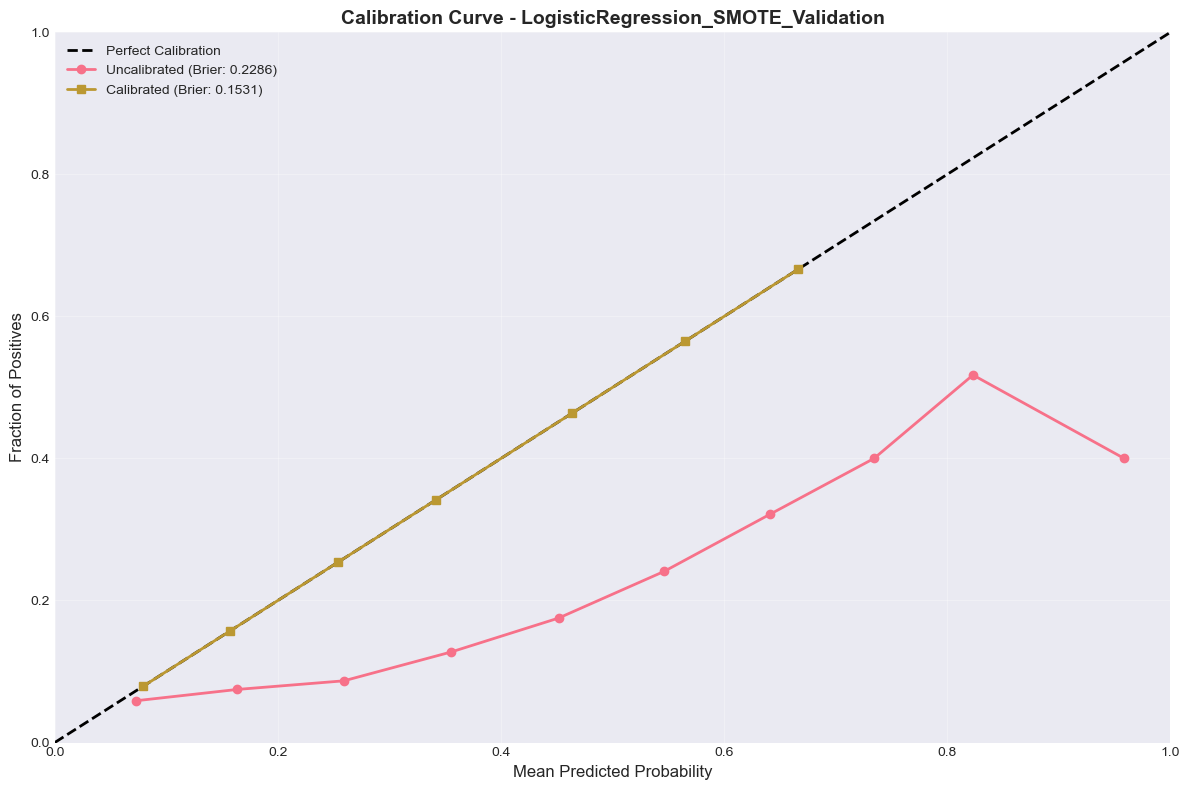

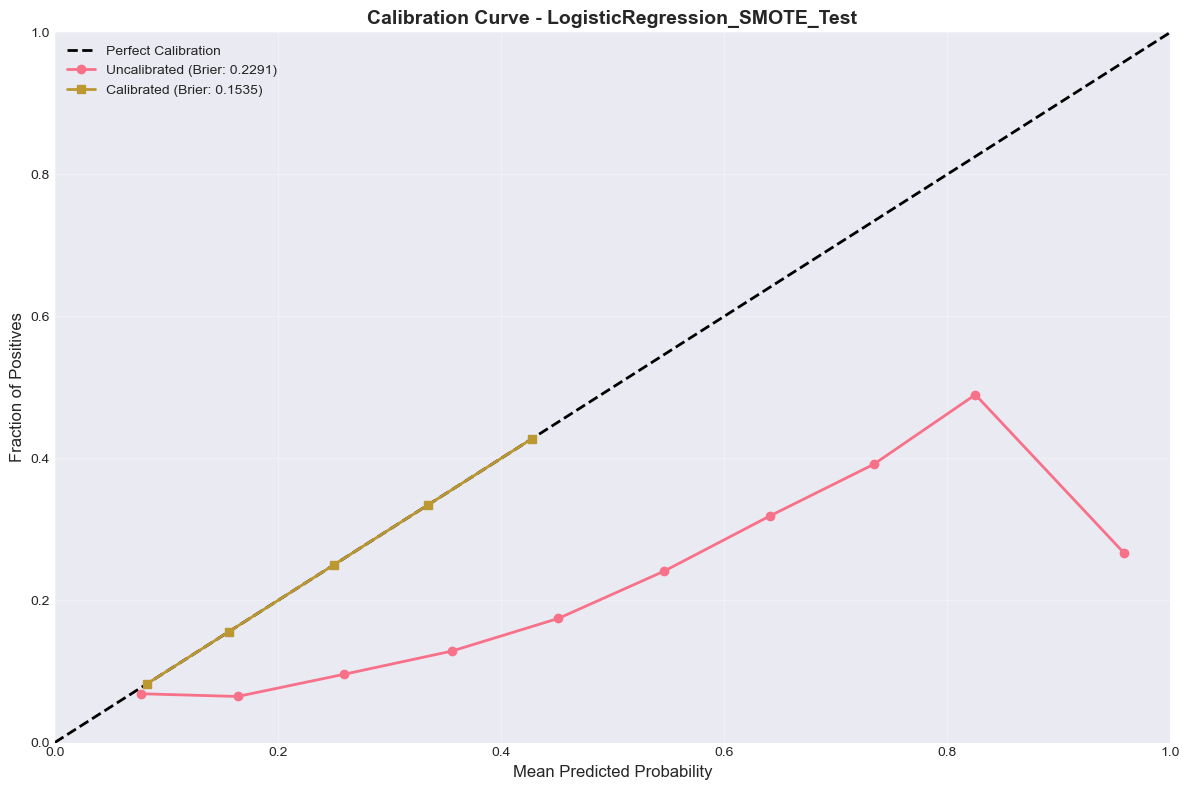

In [7]:
# Plot calibration curves
print("\nGenerating calibration plots...")

# Validation set calibration curve
evaluator.plot_calibration_curve(
    y_val, y_val_proba, y_val_calibrated,
    model_name="LogisticRegression_SMOTE_Validation",
    n_bins=10,
    save=True
)

# Test set calibration curve
evaluator.plot_calibration_curve(
    y_test, y_test_proba, y_test_calibrated,
    model_name="LogisticRegression_SMOTE_Test",
    n_bins=10,
    save=True
)

print("✓ Calibration curves saved")

## 6. Evaluate Model (Validation Set)

In [8]:
print("="*80)
print("VALIDATION SET RESULTS")
print("="*80)

val_metrics = evaluator.evaluate(
    y_val, y_val_proba,
    threshold=optimal_threshold,
    model_name="LogisticRegression_SMOTE_Validation"
)

print("\nKey Metrics:")
print(f"  AUC-ROC: {val_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
print(f"  Precision: {val_metrics['precision']:.4f}")
print(f"  Recall: {val_metrics['recall']:.4f}")
print(f"  F1-Score: {val_metrics['f1_score']:.4f}")
print(f"  PR-AUC: {val_metrics['pr_auc']:.4f}")
print(f"  MCC: {val_metrics['matthews_corr_coef']:.4f}")
print(f"  Cohen's Kappa: {val_metrics['cohen_kappa']:.4f}")

2025-12-10 03:27:00,365 - credit_risk_fyp.evaluation - INFO - Evaluating LogisticRegression_SMOTE_Validation...
INFO:credit_risk_fyp.evaluation:Evaluating LogisticRegression_SMOTE_Validation...
2025-12-10 03:27:00,560 - credit_risk_fyp.evaluation - INFO - LogisticRegression_SMOTE_Validation Results:
INFO:credit_risk_fyp.evaluation:LogisticRegression_SMOTE_Validation Results:
2025-12-10 03:27:00,561 - credit_risk_fyp.evaluation - INFO -   AUC-ROC: 0.6401
INFO:credit_risk_fyp.evaluation:  AUC-ROC: 0.6401
2025-12-10 03:27:00,564 - credit_risk_fyp.evaluation - INFO -   Accuracy: 0.5662
INFO:credit_risk_fyp.evaluation:  Accuracy: 0.5662


VALIDATION SET RESULTS


2025-12-10 03:27:00,566 - credit_risk_fyp.evaluation - INFO -   Precision: 0.2635
INFO:credit_risk_fyp.evaluation:  Precision: 0.2635
2025-12-10 03:27:00,570 - credit_risk_fyp.evaluation - INFO -   Recall: 0.6551
INFO:credit_risk_fyp.evaluation:  Recall: 0.6551
2025-12-10 03:27:00,573 - credit_risk_fyp.evaluation - INFO -   F1-Score: 0.3758
INFO:credit_risk_fyp.evaluation:  F1-Score: 0.3758



Key Metrics:
  AUC-ROC: 0.6401
  Accuracy: 0.5662
  Precision: 0.2635
  Recall: 0.6551
  F1-Score: 0.3758
  PR-AUC: 0.2994
  MCC: 0.1592
  Cohen's Kappa: 0.1279


## 7. Evaluate Model (Test Set)

In [9]:
print("="*80)
print("TEST SET RESULTS")
print("="*80)

test_metrics = evaluator.evaluate(
    y_test, y_test_proba,
    threshold=optimal_threshold,
    model_name="LogisticRegression_SMOTE_Test"
)

print("\nKey Metrics:")
print(f"  AUC-ROC: {test_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
print(f"  PR-AUC: {test_metrics['pr_auc']:.4f}")
print(f"  MCC: {test_metrics['matthews_corr_coef']:.4f}")
print(f"  Cohen's Kappa: {test_metrics['cohen_kappa']:.4f}")

2025-12-10 03:27:00,596 - credit_risk_fyp.evaluation - INFO - Evaluating LogisticRegression_SMOTE_Test...
INFO:credit_risk_fyp.evaluation:Evaluating LogisticRegression_SMOTE_Test...
2025-12-10 03:27:00,724 - credit_risk_fyp.evaluation - INFO - LogisticRegression_SMOTE_Test Results:
INFO:credit_risk_fyp.evaluation:LogisticRegression_SMOTE_Test Results:
2025-12-10 03:27:00,726 - credit_risk_fyp.evaluation - INFO -   AUC-ROC: 0.6365
INFO:credit_risk_fyp.evaluation:  AUC-ROC: 0.6365
2025-12-10 03:27:00,729 - credit_risk_fyp.evaluation - INFO -   Accuracy: 0.5662
INFO:credit_risk_fyp.evaluation:  Accuracy: 0.5662
2025-12-10 03:27:00,731 - credit_risk_fyp.evaluation - INFO -   Precision: 0.2631
INFO:credit_risk_fyp.evaluation:  Precision: 0.2631
2025-12-10 03:27:00,734 - credit_risk_fyp.evaluation - INFO -   Recall: 0.6536
INFO:credit_risk_fyp.evaluation:  Recall: 0.6536
2025-12-10 03:27:00,738 - credit_risk_fyp.evaluation - INFO -   F1-Score: 0.3752
INFO:credit_risk_fyp.evaluation:  F1-Scor

TEST SET RESULTS

Key Metrics:
  AUC-ROC: 0.6365
  Accuracy: 0.5662
  Precision: 0.2631
  Recall: 0.6536
  F1-Score: 0.3752
  PR-AUC: 0.2945
  MCC: 0.1582
  Cohen's Kappa: 0.1271


## 8. Generate Visualizations

2025-12-10 03:27:00,762 - credit_risk_fyp.evaluation - INFO - Generating all evaluation plots for LogisticRegression_SMOTE_Validation...
INFO:credit_risk_fyp.evaluation:Generating all evaluation plots for LogisticRegression_SMOTE_Validation...


Generating evaluation plots...


2025-12-10 03:27:01,724 - credit_risk_fyp.evaluation - INFO - ROC curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\roc_curve_logisticregression_smote_validation.png
INFO:credit_risk_fyp.evaluation:ROC curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\roc_curve_logisticregression_smote_validation.png
2025-12-10 03:27:02,547 - credit_risk_fyp.evaluation - INFO - PR curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\pr_curve_logisticregression_smote_validation.png
INFO:credit_risk_fyp.evaluation:PR curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\pr_curve_logisticregression_smote_validation.png
2025-12-10 03:27:02,989 - credit_risk_fyp.evaluation - INFO - Confusion matrix saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\confusion_matrix_logisticregression_smote_validation.png
INFO:credit_risk_fyp.eval

✓ All plots saved to results/figures/


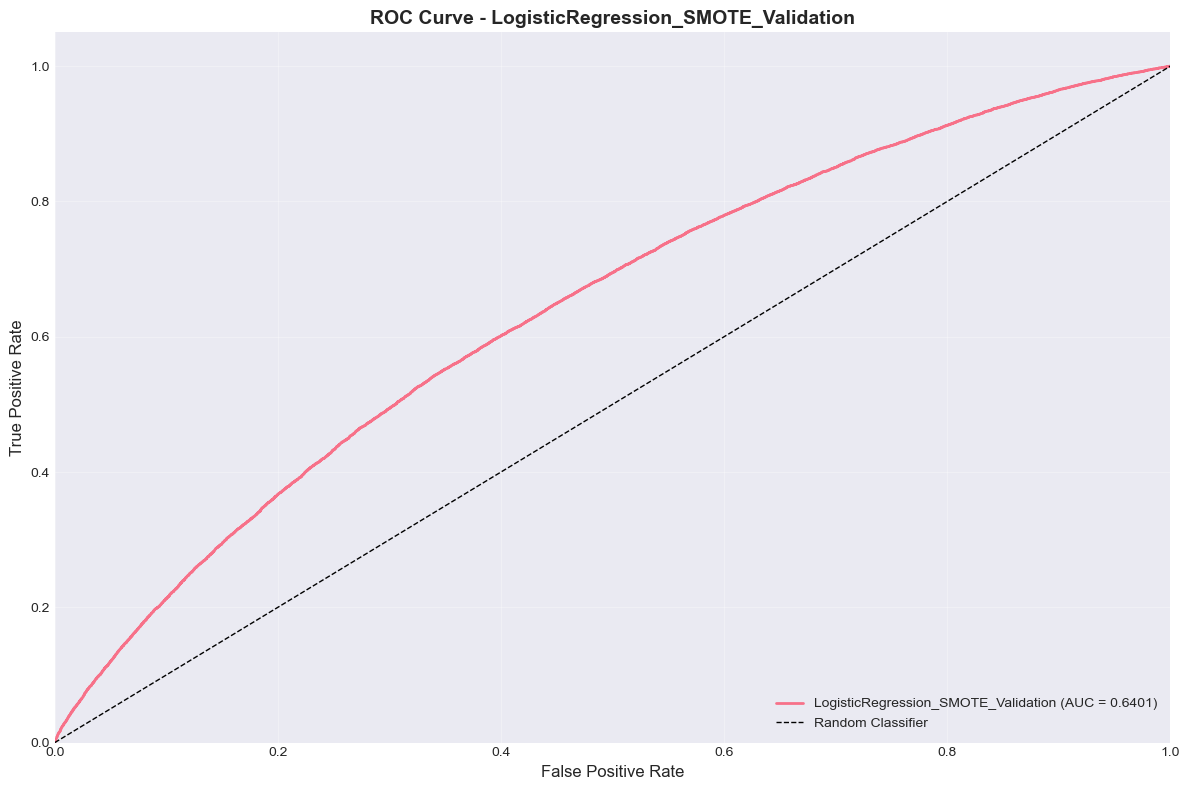

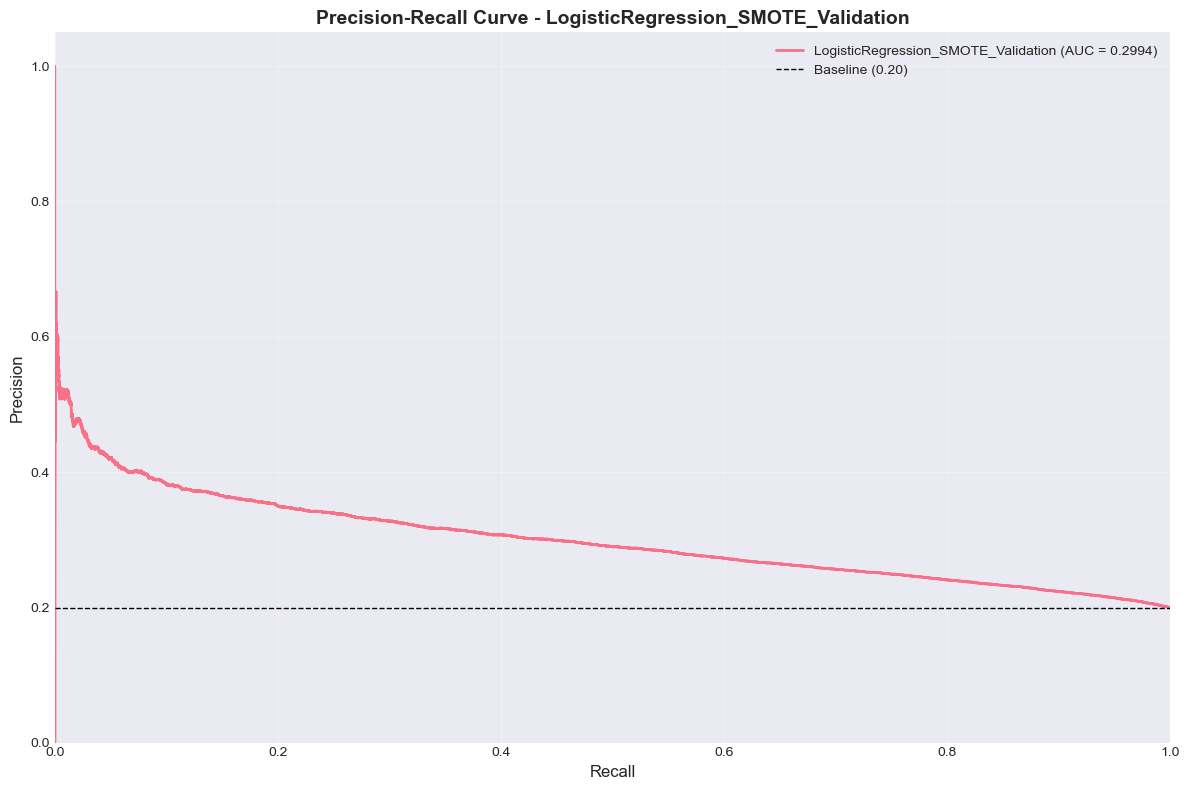

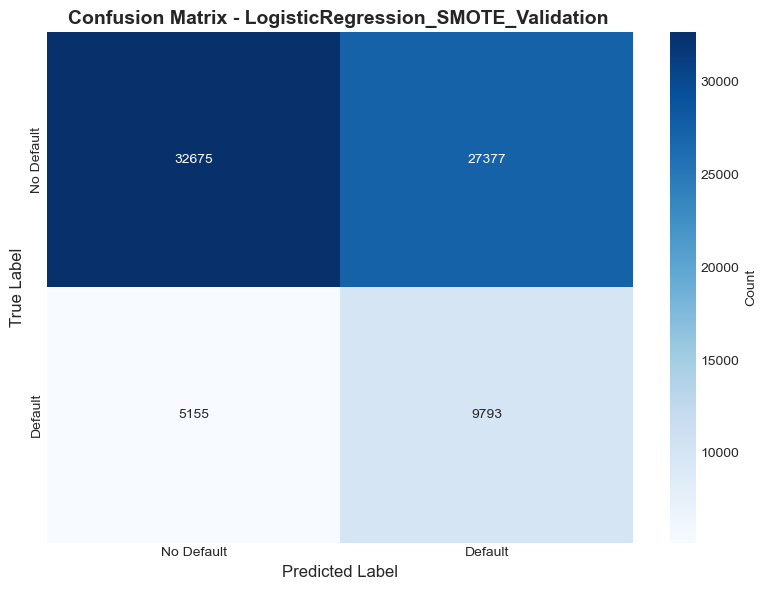

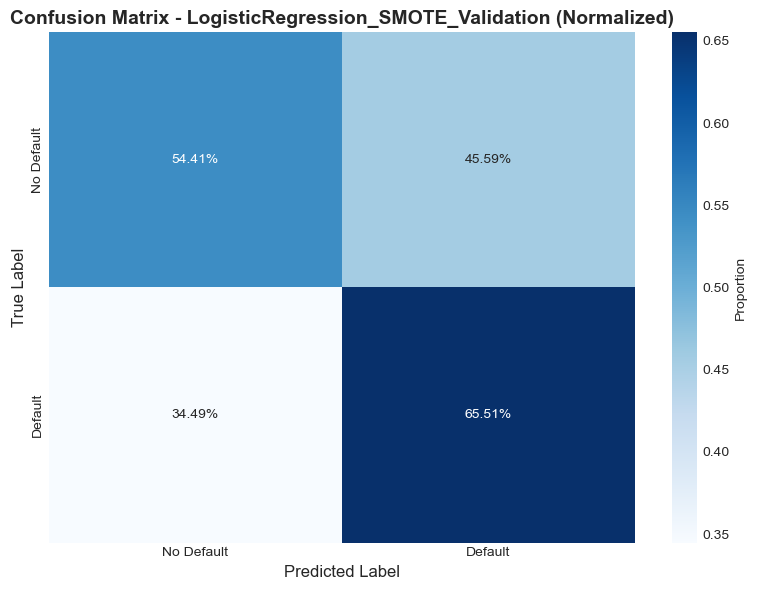

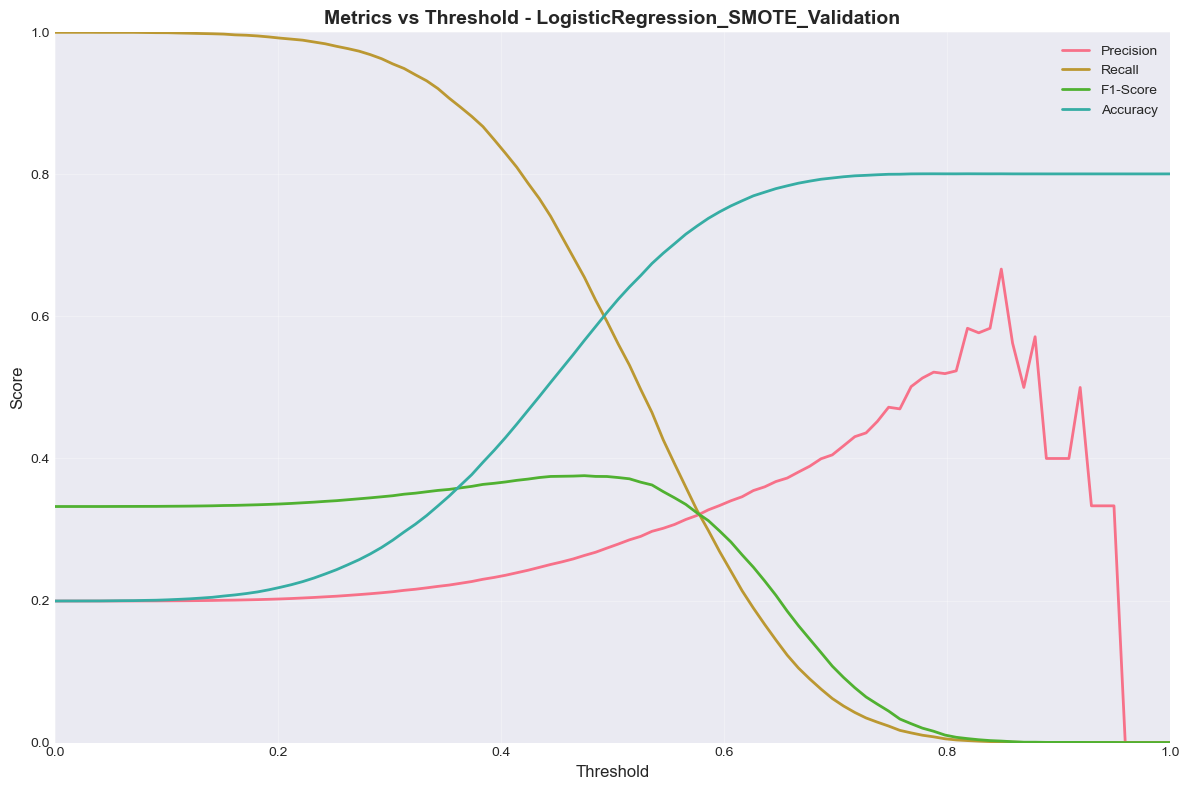

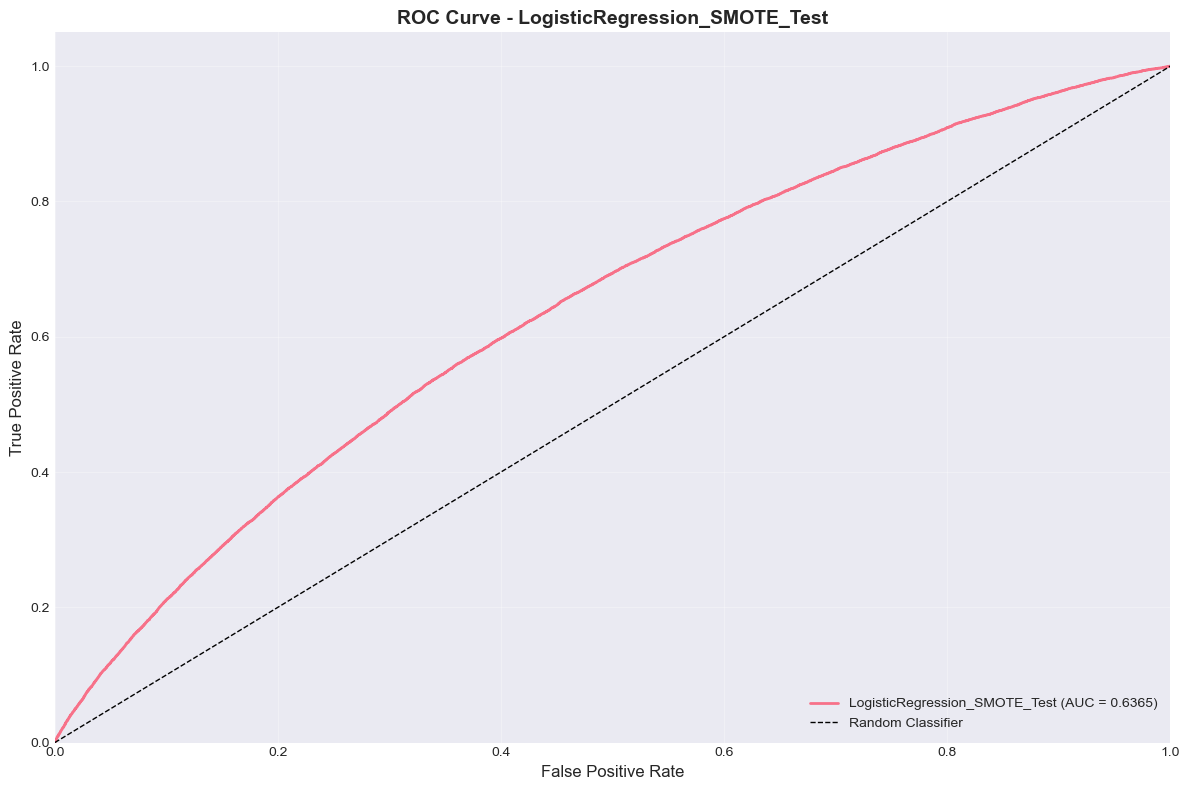

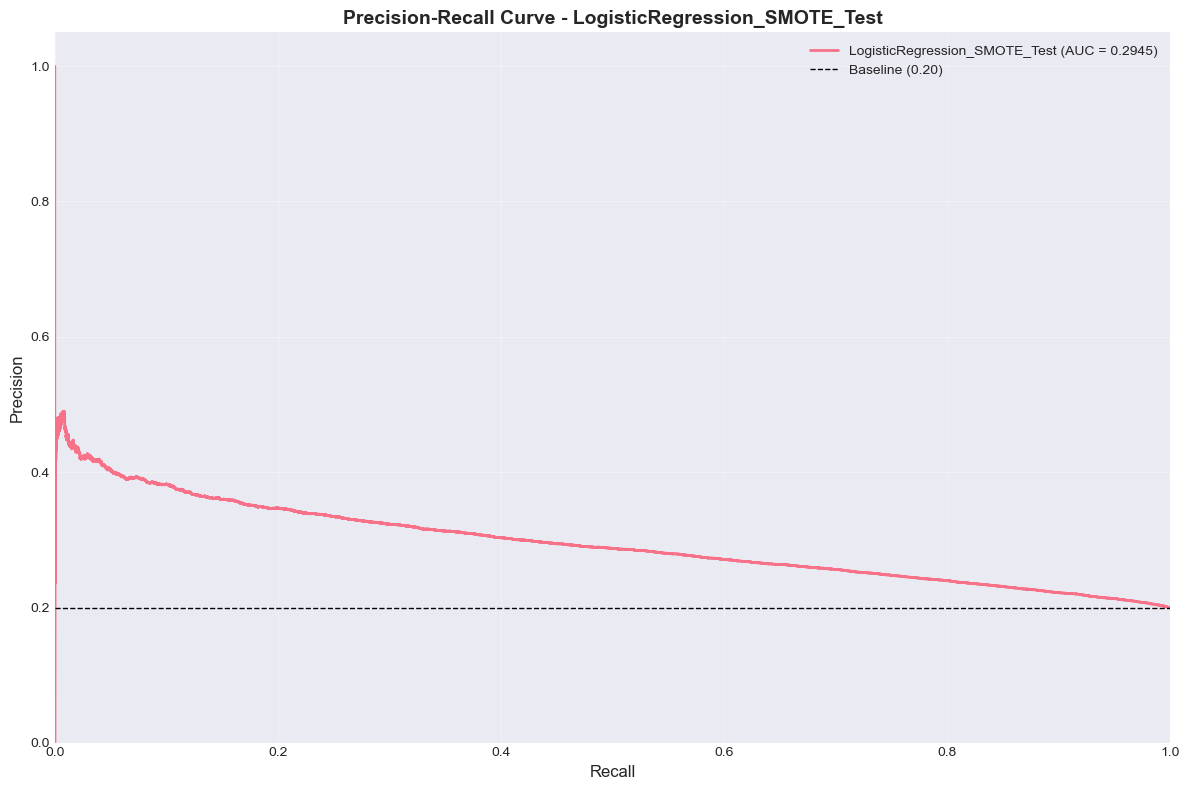

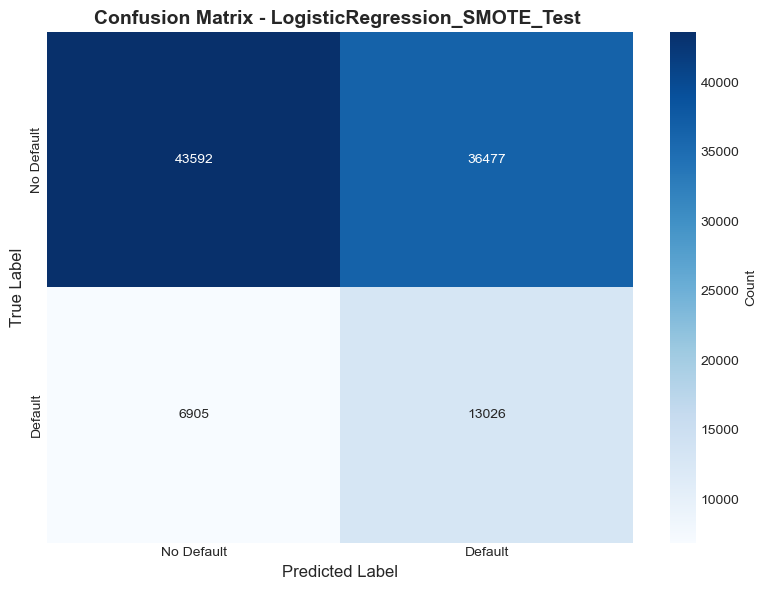

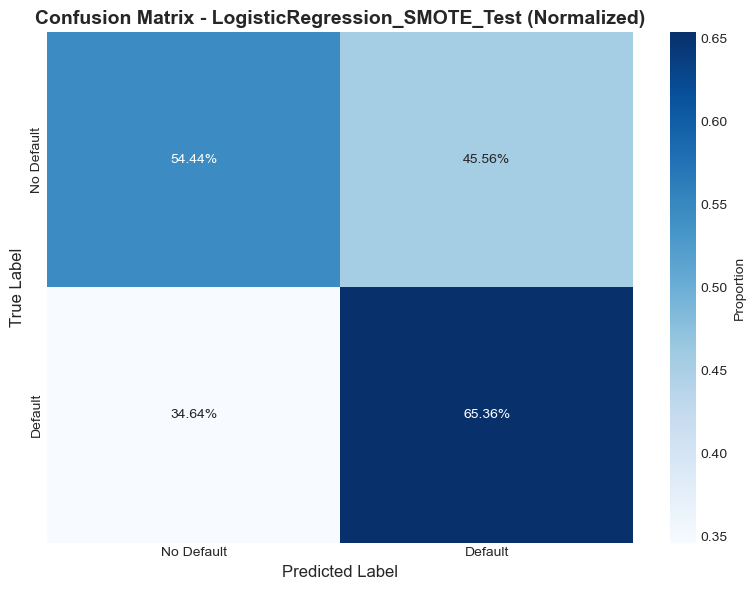

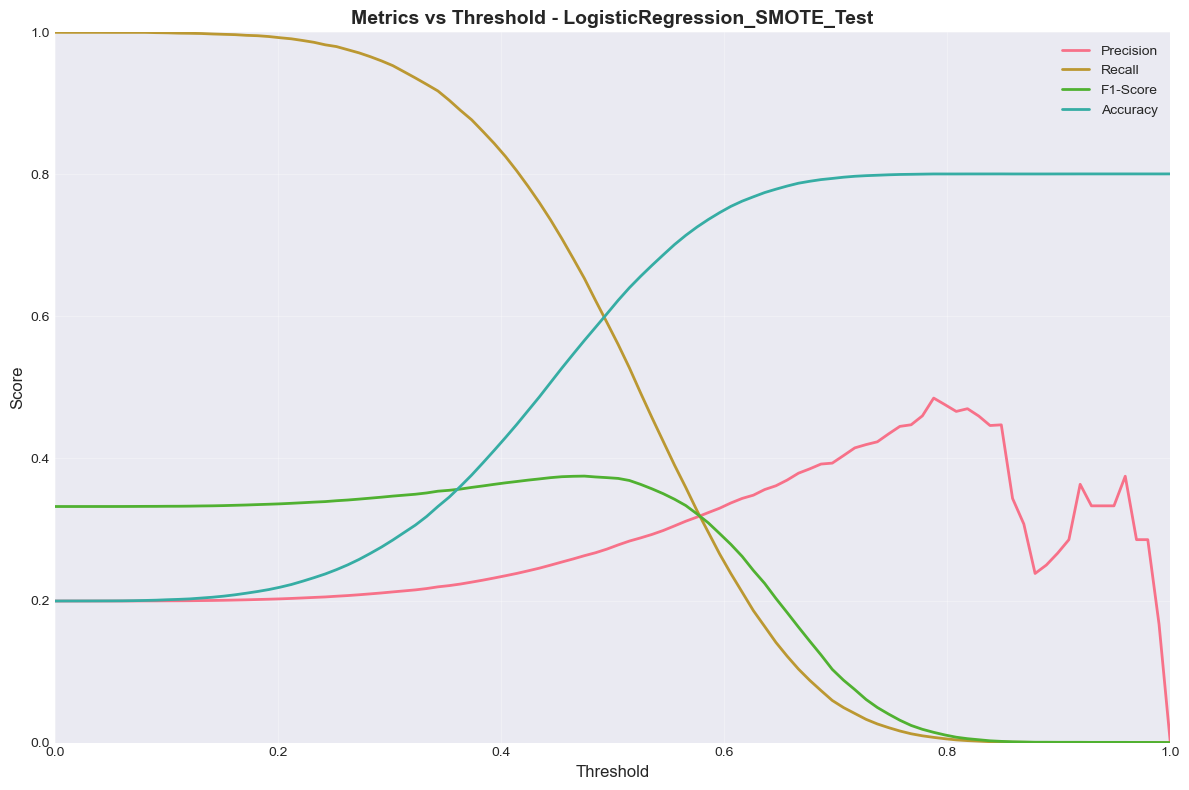

In [10]:
print("Generating evaluation plots...")

val_figures = evaluator.evaluate_all_plots(
    y_val, y_val_proba,
    model_name="LogisticRegression_SMOTE_Validation",
    threshold=optimal_threshold,
    save=True
)

test_figures = evaluator.evaluate_all_plots(
    y_test, y_test_proba,
    model_name="LogisticRegression_SMOTE_Test",
    threshold=optimal_threshold,
    save=True
)

print("✓ All plots saved to results/figures/")

## 9. Feature Importance (Coefficients)

FEATURE IMPORTANCE (LOGISTIC REGRESSION COEFFICIENTS)

Top 20 Most Important Features (by absolute coefficient):

              Feature  Coefficient
  income_x_emp_length    -0.050201
    total_balance_all    -0.048132
 acc_open_past_24mths     0.043375
                  dti     0.041651
       fico_range_low    -0.041378
      fico_range_high    -0.041377
       home_ownership     0.040955
total_credit_accounts     0.037645
   num_tl_op_past_12m     0.037220
        income_bucket    -0.036183
        fico_dti_risk     0.035406
 total_debt_to_income    -0.034710
     loan_amnt_bucket     0.034452
 account_health_score     0.032291
                 term     0.031067
  num_rev_tl_bal_gt_0     0.023590
      num_actv_rev_tl     0.023572
          avg_cur_bal    -0.023478
      tot_hi_cred_lim    -0.022039
            loan_amnt     0.021925


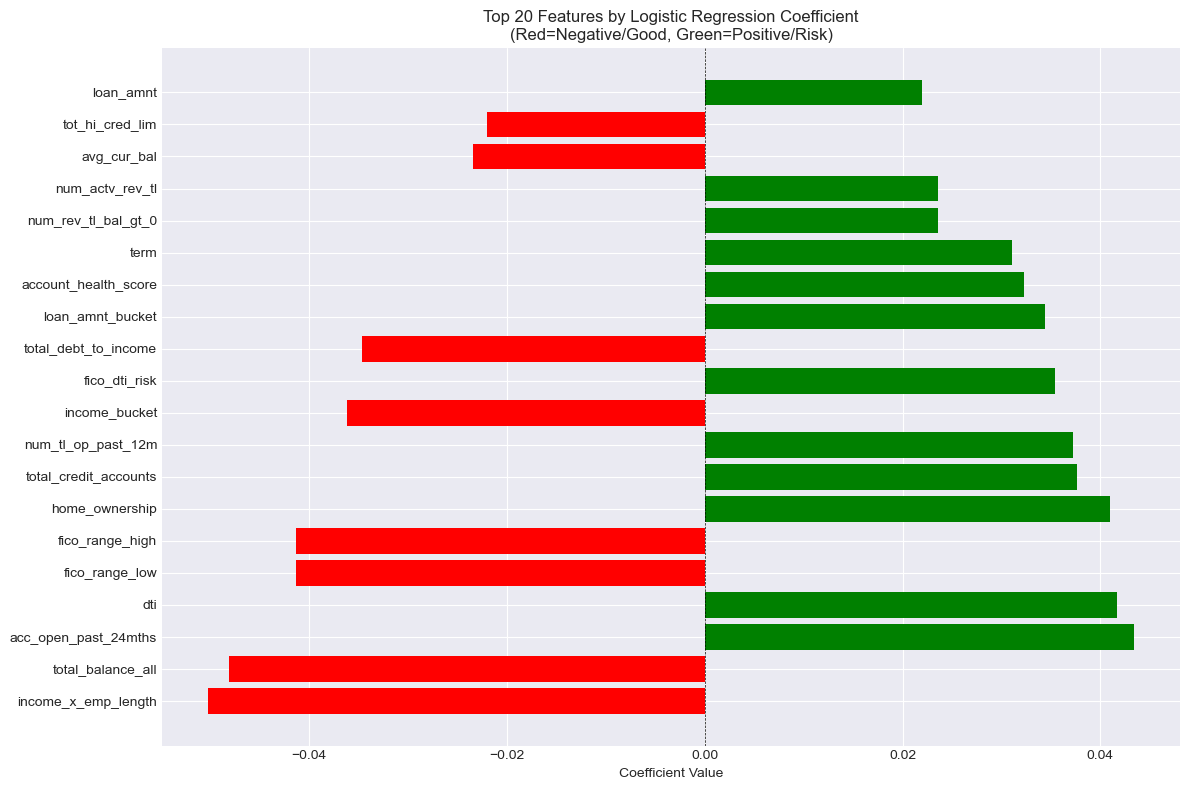


✓ Feature importance plot saved


In [11]:
print("="*80)
print("FEATURE IMPORTANCE (LOGISTIC REGRESSION COEFFICIENTS)")
print("="*80)

# Get feature coefficients
feature_names = X_train.columns
coefficients = lr_model.coef_[0]

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 20 Most Important Features (by absolute coefficient):\n")
print(importance_df.head(20)[['Feature', 'Coefficient']].to_string(index=False))

# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features by Logistic Regression Coefficient\n(Red=Negative/Good, Green=Positive/Risk)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'logistic_regression_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved")

## 10. Model Comparison Summary

In [12]:
print("="*80)
print("MODEL TRAINING SUMMARY - LOGISTIC REGRESSION")
print("="*80)

print(f"\n📊 DATASET INFORMATION:")
print(f"  Training samples: {len(X_train):,} (SMOTE-balanced)")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {X_train.shape[1]}")
print(f"  SMOTE ratio: {train_dist[0]/train_dist[1]:.2f}:1")

print(f"\n🎯 TEST SET PERFORMANCE:")
print(f"  AUC-ROC: {test_metrics['roc_auc']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.4f}")

print(f"\n💾 SAVED ARTIFACTS:")
print(f"  Model: {model_path}")
print(f"  Figures: results/figures/")

print(f"\n✅ TRAINING COMPLETE!")
print("="*80)

MODEL TRAINING SUMMARY - LOGISTIC REGRESSION

📊 DATASET INFORMATION:
  Training samples: 364,313 (SMOTE-balanced)
  Validation samples: 75,000
  Test samples: 100,000
  Features: 103
  SMOTE ratio: 2.50:1

🎯 TEST SET PERFORMANCE:
  AUC-ROC: 0.6365
  Precision: 0.2631
  Recall: 0.6536
  F1-Score: 0.3752
  Optimal Threshold: 0.4747

💾 SAVED ARTIFACTS:
  Model: c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\logistic_regression_smote.pkl
  Figures: results/figures/

✅ TRAINING COMPLETE!


## 11. Detailed Classification Metrics (TPR/FPR)

In [13]:
print("="*80)
print("DETAILED CLASSIFICATION METRICS")
print("="*80)

print(f"\n📊 CONFUSION MATRIX BREAKDOWN:")
print(f"  True Positives (TP):  {test_metrics['true_positives']:,}")
print(f"  True Negatives (TN):  {test_metrics['true_negatives']:,}")
print(f"  False Positives (FP): {test_metrics['false_positives']:,}")
print(f"  False Negatives (FN): {test_metrics['false_negatives']:,}")

print(f"\n🎯 RATES & SPECIFICITY:")
print(f"  TPR (True Positive Rate / Recall):  {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"  FPR (False Positive Rate):          {test_metrics['false_positive_rate']:.4f} ({test_metrics['false_positive_rate']*100:.2f}%)")
print(f"  TNR (True Negative Rate / Specificity): {test_metrics['specificity']:.4f} ({test_metrics['specificity']*100:.2f}%)")
print(f"  FNR (False Negative Rate):          {test_metrics['false_negative_rate']:.4f} ({test_metrics['false_negative_rate']*100:.2f}%)")

print(f"\n💡 INTERPRETATION:")
print(f"  • Out of 100 actual defaulters, we correctly identify {test_metrics['recall']*100:.1f}")
print(f"  • Out of 100 good loans, we incorrectly flag {test_metrics['false_positive_rate']*100:.1f} as risky")
print(f"  • Out of 100 good loans, we correctly identify {test_metrics['specificity']*100:.1f} as good")

print(f"\n🔍 MODEL COMPARISON:")
# XGBoost results (from previous notebook)
xgb_metrics = {
    'roc_auc': 0.7249,
    'precision': 0.3415,
    'recall': 0.6269,
    'f1_score': 0.4421,
    'fpr': 0.3586
}

print(f"\n{'Metric':<20} {'XGBoost':<12} {'LogReg':<12} {'Difference':<15}")
print("-" * 60)
print(f"{'AUC-ROC':<20} {xgb_metrics['roc_auc']:<12.4f} {test_metrics['roc_auc']:<12.4f} {test_metrics['roc_auc']-xgb_metrics['roc_auc']:+.4f}")
print(f"{'Precision':<20} {xgb_metrics['precision']:<12.4f} {test_metrics['precision']:<12.4f} {test_metrics['precision']-xgb_metrics['precision']:+.4f}")
print(f"{'Recall (TPR)':<20} {xgb_metrics['recall']:<12.4f} {test_metrics['recall']:<12.4f} {test_metrics['recall']-xgb_metrics['recall']:+.4f}")
print(f"{'F1-Score':<20} {xgb_metrics['f1_score']:<12.4f} {test_metrics['f1_score']:<12.4f} {test_metrics['f1_score']-xgb_metrics['f1_score']:+.4f}")
print(f"{'FPR':<20} {xgb_metrics['fpr']:<12.4f} {test_metrics['false_positive_rate']:<12.4f} {test_metrics['false_positive_rate']-xgb_metrics['fpr']:+.4f}")

print("\n" + "="*80)

DETAILED CLASSIFICATION METRICS

📊 CONFUSION MATRIX BREAKDOWN:
  True Positives (TP):  13,026
  True Negatives (TN):  43,592
  False Positives (FP): 36,477
  False Negatives (FN): 6,905

🎯 RATES & SPECIFICITY:
  TPR (True Positive Rate / Recall):  0.6536 (65.36%)
  FPR (False Positive Rate):          0.4556 (45.56%)
  TNR (True Negative Rate / Specificity): 0.5444 (54.44%)
  FNR (False Negative Rate):          0.3464 (34.64%)

💡 INTERPRETATION:
  • Out of 100 actual defaulters, we correctly identify 65.4
  • Out of 100 good loans, we incorrectly flag 45.6 as risky
  • Out of 100 good loans, we correctly identify 54.4 as good

🔍 MODEL COMPARISON:

Metric               XGBoost      LogReg       Difference     
------------------------------------------------------------
AUC-ROC              0.7249       0.6365       -0.0884
Precision            0.3415       0.2631       -0.0784
Recall (TPR)         0.6269       0.6536       +0.0267
F1-Score             0.4421       0.3752       -0.0669
F

In [14]:
import pickle

# Save metrics to pickle file for easy loading
metrics_to_save = {
    'test_metrics': test_metrics,
    'optimal_threshold': optimal_threshold
}

metrics_path = RESULTS_DIR / 'logistic_regression_metrics.pkl'
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics_to_save, f)

print(f"✓ Metrics saved to: {metrics_path}")

# Also save predictions CSV
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_test_proba,
    'y_pred': (y_test_proba >= optimal_threshold).astype(int)
})

predictions_path = RESULTS_DIR / 'logistic_regression_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)

print(f"✓ Predictions saved to: {predictions_path}")
print("\n" + "="*80)
print("✅ ALL RESULTS SAVED!")
print("="*80)

✓ Metrics saved to: c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\logistic_regression_metrics.pkl
✓ Predictions saved to: c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\logistic_regression_predictions.csv

✅ ALL RESULTS SAVED!


## 12. Save Results for Model Comparison